# Baja todos los datos de Kaggle


In [ ]:
%%bash
mkdir -p ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

mkdir kaggle_original_data
cd kaggle_original_data
kaggle competitions download -c noaa-right-whale-recognition


mkdir /content/whale_images
cd /content/whale_images
unzip -q /content/kaggle_original_data/imgs.zip


#Imports

In [ ]:
# OS
from pathlib import Path
import os, shutil

# Data
import numpy as np
import pandas as pd 

#Imágenes
import cv2
import imagesize #Librería para ver el tamaño de una imagen sin cargarla toda en memmoria, otras como cv2 librerías cargan toda la imagen y trada mucho en procesarla

# Gáficos
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
%matplotlib inline

#Crea los directiorios y visualiza algunos samples

In [27]:
#Estructuramos los directorios de trabajo


base_dir = './whale_images'
image_dir =  './whale_images/imgs' 
train_dir =  './whale_images/train'
validation_dir =  './whale_images/validation' 
original_data= './kaggle_original_data'

# Directorios para los splits de
# entrenamiento, validación 
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)

# Copia una imagen que faltaba en el los archivos y está en el CSV (estaba como ejjemplo en la raiz)
src = os.path.join(original_data, 'w_7489.jpg')
dst = os.path.join(image_dir, 'w_7489.jpg')
shutil.copyfile(src, dst)




'./whale_images/imgs/w_7489.jpg'

width=5184, height=3456, depth=3


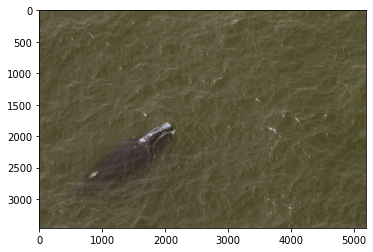

width=3229, height=2152, depth=3


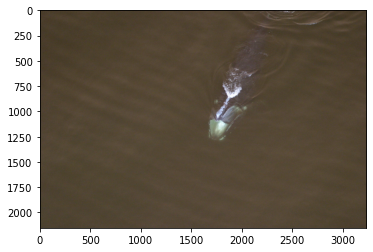

width=2859, height=1906, depth=3


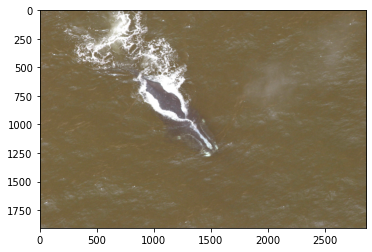

width=2999, height=2000, depth=3


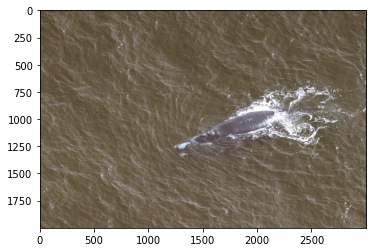

width=5040, height=3360, depth=3


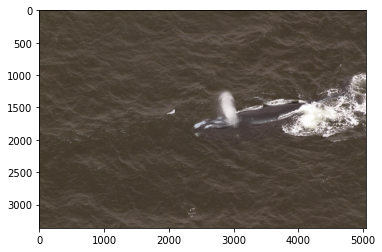

In [247]:

# Elegimos 5 imágenes
random_whales = [os.path.join(image_dir, fname)
               for fname in np.random.choice(os.listdir(image_dir), 5)]

# Mostramos las imágenes
for whale in random_whales:
  cv_whale = cv2.imread(whale)
  plt.imshow(cv_whale)
  (h, w, d) = cv_whale.shape
  print("width={}, height={}, depth={}".format(w, h, d))
  #plt.axis('off')
  plt.show()


#Exploramos y copiamos las imágenes etiquetadas a Train

In [267]:
#Vemos cuantas bellenas
print (image_dir)
DIR = image_dir
number_of_files = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
print("Archivos:", number_of_files)

train_files = pd.read_csv(os.path.join(original_data  , 'train.csv')) 

# agregamos las resoluciones de las imágenes
# copiamos las etiquetadas al dir de train (despues veremos que copiamos al de validation)
# en un momento w_7489.jpg faltba del direcorio de imágenes, por eso los checks

missing = 0
total = 0
for i, line in train_files.iterrows():
  file_name = Path(os.path.join(image_dir, line['Image'])) 
  dest_name = Path(os.path.join(train_dir, line['Image']))
  if file_name.is_file():
    w, h = imagesize.get(file_name)
    train_files.at [i,'IMG_Height']  =h
    train_files.at [i,'IMG_Width'] = w
    shutil.copyfile(file_name, dest_name)
    #print("File={}, width={}, height={}".format(line['Image'],w, h))
  else: 
    missing+=1
    print(file_name)
  total+=1
print("Etiquetadas:  Total={}, Missing={}, OK={}".format(total, missing, total-missing))

print(train_files.head())




./whale_images/imgs
Archivos: 11470
Etiquetadas:  Total=4544, Missing=0, OK=4544
        Image      whaleID  IMG_Height  IMG_Width
0  w_7812.jpg  whale_48813      2048.0     3072.0
1  w_4598.jpg  whale_09913      2048.0     3072.0
2  w_3828.jpg  whale_45062      2048.0     3072.0
3  w_8734.jpg  whale_74162      2048.0     3072.0
4  w_3251.jpg  whale_99558      2048.0     3072.0


Estos gráficos me parecieron interesantes poruqe vemos las resoluciones de las imágenes están agrupadas y a demas que la relacios entre W y H es casi siempre la misma, alrededor de 1.5. Eso quiere decir que no vamos a tener problemas de distorción si las escalamos. 

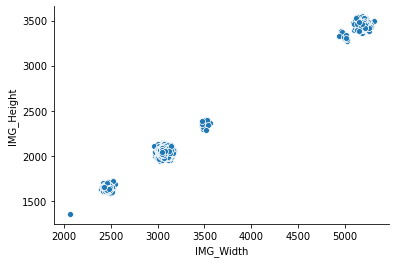

In [268]:
#Hacemos un scatterplot con Jitter para ver la resolución de la imágenes
 

def jitterize(df, mu, sigma):
  noise = np.random.normal(mu, sigma, df.shape )
  return df+noise 

df = jitterize(train_files[['IMG_Width', 'IMG_Height']], 0, 30)

sns.scatterplot (x='IMG_Width', y='IMG_Height', data=df)

sns.despine()



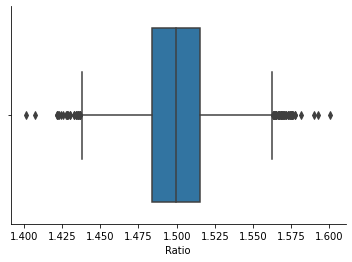

In [269]:
df ['Ratio'] = df['IMG_Width']/df['IMG_Height'] 
sns.boxplot (x='Ratio',  data=df)
sns.despine()

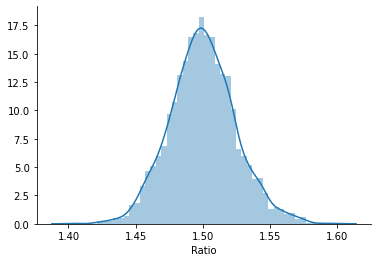

In [270]:

sns.distplot (df ['Ratio'] )
sns.despine()

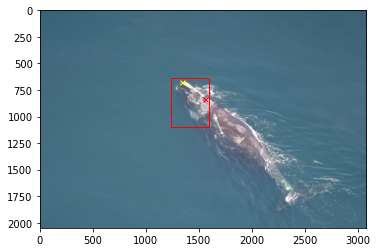

In [271]:
#Prueba de dibujo de las coordenadas

img = matplotlib.image.imread('./whale_images/train/w_5383.jpg')

figure, ax = plt.subplots(1)
rect = matplotlib.patches.Rectangle((1236,638),358,456, edgecolor='r', facecolor="none")

plt.plot (1344,678,  marker="x", color="yellow", markersize=5)
plt.plot (1561,836,  marker="x", color="red", markersize=5)


ax.imshow(img)
ax.add_patch(rect)

In [ ]:
import json 

def flatten_column (df_new, column, dict=False):
  new_col_names = pd.DataFrame(df_new [column][0]).columns


  for c in new_col_names:
    if c in df_new.columns:
      df_new.drop(c, axis='columns', inplace=True)
    df_new.insert(0,c, pd.NA)

  for i, line in df_new.iterrows():
    if dict:
      flat_list = pd.DataFrame.from_dict(df_new.iloc [i] [column])
    else:  
      flat_list = pd.DataFrame(df_new.iloc [i] [column])
    for c in new_col_names:
      df_new.loc[i,c] = flat_list.loc[0,c]

  return df_new


In [273]:
head_rects = pd.read_json('slot.json', orient='columns')

head_rects = flatten_column (head_rects, 'annotations' )

head_rects.drop (['annotations', 'class'], axis='columns', inplace=True )

#train_files = train_files.set_index('Image').join(head_rects.set_index('filename'))
#train_files.reset_index(inplace=True)
train_files.head()

,Image,whaleID,IMG_Height,IMG_Width
0,w_7812.jpg,whale_48813,2048.0,3072.0
1,w_4598.jpg,whale_09913,2048.0,3072.0
2,w_3828.jpg,whale_45062,2048.0,3072.0
3,w_8734.jpg,whale_74162,2048.0,3072.0
4,w_3251.jpg,whale_99558,2048.0,3072.0


In [274]:
dir_points = pd.read_json('indygo_annos_all.json', orient='columns')
dir_points = flatten_column (dir_points, 'annotation', dict=True )
dir_points.drop (['annotation', 'score'], axis='columns', inplace=True )
dir_points.head(5)

,coord1,coord2,name
0,"[1541, 1234]","[1256, 1110]",w_11096.jpg
1,"[1735, 1128]","[2030, 963]",w_10973.jpg
2,"[2645, 1592]","[2680, 1213]",w_10442.jpg
3,"[3011, 775]","[2611, 920]",w_10606.jpg
4,"[2068, 950]","[2058, 1384]",w_11167.jpg


In [275]:
anotated_train = train_files.set_index('Image').join(head_rects.set_index('filename')).join(dir_points.set_index('name'))
anotated_train.reset_index(inplace=True)
anotated_train.head(5)

,Image,whaleID,IMG_Height,IMG_Width,y,x,width,height,coord1,coord2
0,w_7812.jpg,whale_48813,2048.0,3072.0,999.341,1502.9,342.631,438.672,"[1675, 1366]","[1648, 1108]"
1,w_4598.jpg,whale_09913,2048.0,3072.0,1078.37,1252.81,541.451,484.814,"[1638, 1210]","[1349, 1263]"
2,w_3828.jpg,whale_45062,2048.0,3072.0,832.837,1022.78,445.641,282.483,"[1119, 896]","[1344, 963]"
3,w_8734.jpg,whale_74162,2048.0,3072.0,1005.38,1539.1,263.758,294.788,"[1690, 1218]","[1682, 1069]"
4,w_3251.jpg,whale_99558,2048.0,3072.0,640.639,1386.92,514.556,511.148,"[1655, 1068]","[1659, 878]"


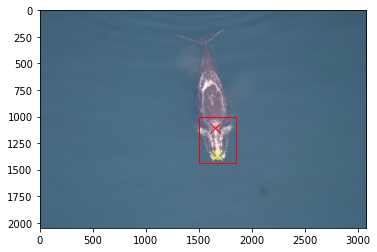

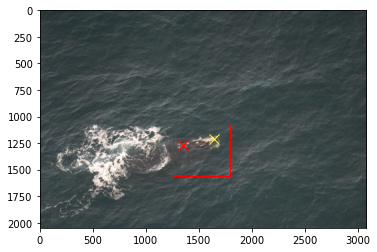

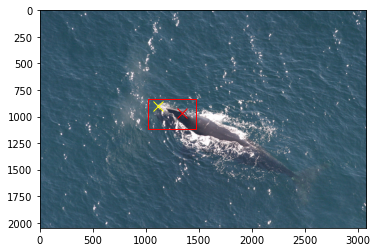

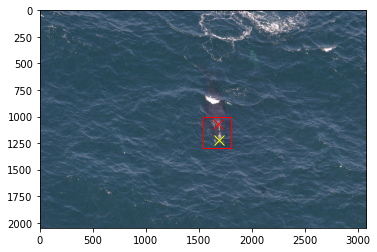

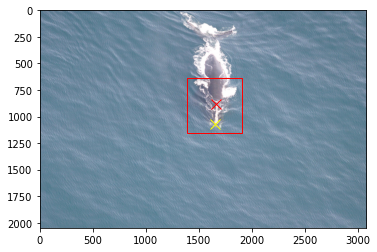

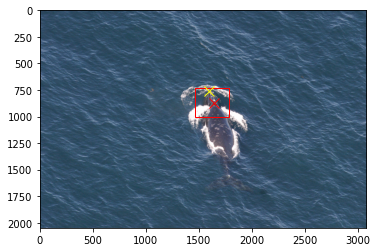

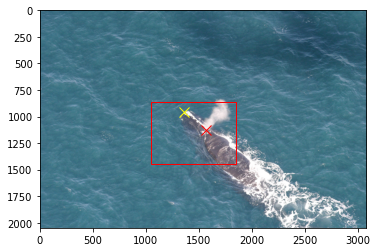

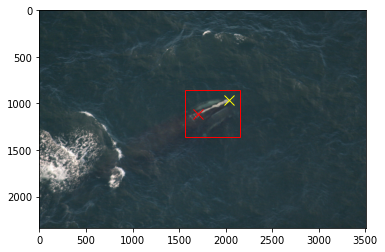

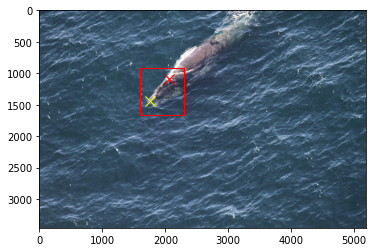

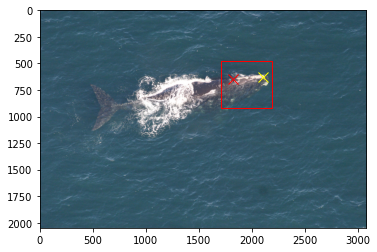

In [281]:
#Prueba de dibujo los rectángulos de jason


for i, line in anotated_train.head(10).iterrows():

  img = matplotlib.image.imread(os.path.join(image_dir, line['Image']))
  figure, ax = plt.subplots(1)
  rect = matplotlib.patches.Rectangle((line['x'],line['y']),line['width'],line['height'], edgecolor='r', facecolor="none")
  plt.plot (line['coord1'][0],line['coord1'][1],  marker="x", color="yellow", markersize=10)
  plt.plot (line['coord2'][0],line['coord2'][1],  marker="x", color="red", markersize=10)


  ax.imshow(img)
  ax.add_patch(rect)